
 ### **Task 1: Training a DQN Agent on the Racetrack Environment**
- Implement a **Deep Q-Network (DQN) agent from scratch** using the provided configuration file (`config.py`).
- Documentation on https://highway-env.farama.org/
- The training process should be documented, including:
  - Observations of different learning phases.
  - Performance evaluation of the trained agent.
  - Analysis of achieved rewards and behavior.


## 0 - Imports

In [9]:
import gymnasium as gym
import matplotlib.pyplot as plt
import highway_env
import torch 
import torch.nn as nn
import torch.optim as optim
import numpy as np

from config import *

## 1 - DQN training  

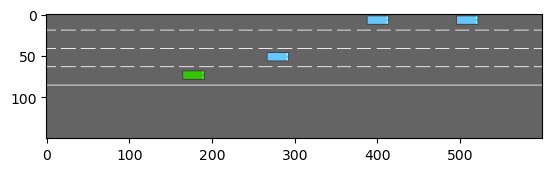

In [2]:
# Create and configure environment
env = gym.make("highway-fast-v0", render_mode="rgb_array")
env.unwrapped.configure(config_dict)  # Use unwrapped environment to configure
env.reset()
plt.imshow(env.render())
plt.show()

In [20]:
import numpy as np
import random
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class DQN(nn.Module):
    """Deep Q-Network model with flexible input dimensions."""
    def __init__(self, state_dim, action_dim, hidden_dim=64):
        """
        Initialize the DQN model.
        
        Args:
            state_dim (tuple): Shape of the state space
            action_dim (int): Number of possible actions
            hidden_dim (int): Size of hidden layers
        """
        super(DQN, self).__init__()
        
        # Calculate flattened input dimension
        self.state_dim = state_dim
        flattened_dim = 1
        for dim in state_dim:
            flattened_dim *= dim
        
        # Network architecture
        self.fc1 = nn.Linear(flattened_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_dim)
        
    def forward(self, x):
        """Forward pass through the network."""
        # Flatten the input if it's multi-dimensional
        if len(x.shape) > 2:  # If we have batch dimension
            x = x.view(x.size(0), -1)
        else:
            x = x.view(-1)
            
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

class DQNAgent:
    """DQN Agent implementation with experience replay and target network."""
    def __init__(self, env, config):
        """
        Initialize the DQN Agent.
        
        Args:
            env: The environment
            config: Configuration dictionary with hyperparameters
        """
        self.env = env
        self.config = config
        
        # Check and set state/action dimensions from environment
        self.state_dim = env.observation_space.shape
        self.action_dim = env.action_space.n
        print(f"Initialized DQN Agent with state dim: {self.state_dim}, action dim: {self.action_dim}")
        
        # Initialize Q-network and target network
        self.q_network = DQN(self.state_dim, self.action_dim, config['hidden_dim'])
        self.target_network = DQN(self.state_dim, self.action_dim, config['hidden_dim'])
        self.target_network.load_state_dict(self.q_network.state_dict())
        
        # Initialize optimizer and replay buffer
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=config['lr'])
        self.replay_buffer = deque(maxlen=config['buffer_size'])
        
        # Training variables
        self.steps_done = 0
        self.epsilon = config['epsilon_start']
        
        # Device (GPU if available)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.q_network.to(self.device)
        self.target_network.to(self.device)
        
    def get_action(self, state, eval_mode=False):
        """
        Select action using epsilon-greedy policy.
        
        Args:
            state: Current state
            eval_mode: If True, uses greedy policy (for evaluation)
            
        Returns:
            action: Selected action
        """
        if not eval_mode and random.random() < self.epsilon:
            return self.env.action_space.sample()
        
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            q_values = self.q_network(state)
        return q_values.argmax().item()
    
    def update_epsilon(self):
        """Update epsilon using linear decay."""
        self.epsilon = max(
            self.config['epsilon_end'],
            self.config['epsilon_start'] - 
            (self.steps_done / self.config['epsilon_decay'])
        )
    
    def store_transition(self, state, action, reward, next_state, done):
        """Store transition in replay buffer."""
        self.replay_buffer.append((
            torch.FloatTensor(state),
            torch.LongTensor([action]),
            torch.FloatTensor([reward]),
            torch.FloatTensor(next_state),
            torch.FloatTensor([done])
        ))
    
    def sample_batch(self):
        """Sample a batch of transitions from replay buffer."""
        batch = random.sample(self.replay_buffer, self.config['batch_size'])
        states, actions, rewards, next_states, dones = zip(*batch)
        
        return (
            torch.stack(states).to(self.device),
            torch.stack(actions).to(self.device),
            torch.stack(rewards).to(self.device),
            torch.stack(next_states).to(self.device),
            torch.stack(dones).to(self.device)
        )
    
    def train_step(self):
        """Perform one training step on a batch from replay buffer."""
        if len(self.replay_buffer) < self.config['batch_size']:
            return 0  # Not enough samples yet
        
        # Sample batch
        states, actions, rewards, next_states, dones = self.sample_batch()
        
        # Compute current Q values
        current_q = self.q_network(states).gather(1, actions)
        
        # Compute target Q values
        with torch.no_grad():
            next_q = self.target_network(next_states).max(1, keepdim=True)[0]
            target_q = rewards + (1 - dones) * self.config['gamma'] * next_q
        
        # Compute loss and optimize
        loss = F.mse_loss(current_q, target_q)
        self.optimizer.zero_grad()  # Fixed: using correct attribute name
        loss.backward()
        self.optimizer.step()  # Fixed: using correct attribute name
        
        # Update target network
        if self.steps_done % self.config['target_update'] == 0:
            self.target_network.load_state_dict(self.q_network.state_dict())
        
        self.steps_done += 1
        self.update_epsilon()
        
        return loss.item()

In [21]:
import time
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd
import os

def train_dqn_agent(env, agent, config, n_episodes=1000, save_dir="models"):
    """
    Train the DQN agent with logging and model saving.
    
    Args:
        env: The environment
        agent: DQN agent
        config: Configuration dictionary
        n_episodes: Number of training episodes
        save_dir: Directory to save models and logs
    """
    # Create save directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    
    # Training statistics
    stats = defaultdict(list)
    episode_rewards = []
    episode_lengths = []
    episode_losses = []
    epsilon_values = []
    
    # Training loop
    start_time = time.time()
    print("Starting training...")
    
    for episode in range(1, n_episodes + 1):
        state, _ = env.reset()
        done = False
        total_reward = 0
        total_loss = 0
        step = 0
        
        while not done:
            # Select and perform action
            action = agent.get_action(state)
            next_state, reward, done, truncated, info = env.step(action)
            done = done or truncated
            
            # Store transition and train
            agent.store_transition(state, action, reward, next_state, done)
            loss = agent.train_step()
            
            if loss:  # Only count loss if training happened
                total_loss += loss
            
            state = next_state
            total_reward += reward
            step += 1
        
        # Update statistics
        episode_rewards.append(total_reward)
        episode_lengths.append(step)
        if total_loss > 0:  # Only append loss if training happened
            avg_loss = total_loss / step
            episode_losses.append(avg_loss)
        else:
            episode_losses.append(0)
        epsilon_values.append(agent.epsilon)
        
        # Print episode summary
        if episode % 10 == 0:
            avg_reward = np.mean(episode_rewards[-10:])
            avg_loss = np.mean(episode_losses[-10:]) if episode_losses[-10:] else 0
            print(f"Episode {episode:4d} | Reward: {total_reward:6.1f} | "
                  f"Avg Reward (10): {avg_reward:6.1f} | Length: {step:3d} | "
                  f"Loss: {avg_loss:6.2f} | Epsilon: {agent.epsilon:.3f}")
        
        # Save model periodically
        if episode % 100 == 0:
            model_path = os.path.join(save_dir, f"dqn_episode_{episode}.pth")
            agent.save_model(model_path)
            print(f"Saved model to {model_path}")
    
    # Save final model
    final_model_path = os.path.join(save_dir, "dqn_final.pth")
    agent.save_model(final_model_path)
    
    # Save training statistics
    training_stats = {
        'episode': list(range(1, n_episodes + 1)),
        'reward': episode_rewards,
        'length': episode_lengths,
        'loss': episode_losses,
        'epsilon': epsilon_values
    }
    stats_df = pd.DataFrame(training_stats)
    stats_path = os.path.join(save_dir, "training_stats.csv")
    stats_df.to_csv(stats_path, index=False)
    
    # Print summary
    duration = time.time() - start_time
    print(f"\nTraining completed in {duration:.2f} seconds")
    print(f"Final 10 episodes average reward: {np.mean(episode_rewards[-10:]):.1f}")
    print(f"Models and stats saved to {save_dir}")
    
    return stats_df

# Default hyperparameters (can be adjusted)
config = {
    'hidden_dim': 128,           # Size of hidden layers in Q-network
    'lr': 3e-4,                  # Learning rate
    'buffer_size': 100000,       # Replay buffer size
    'batch_size': 64,            # Batch size for training
    'gamma': 0.99,              # Discount factor
    'epsilon_start': 1.0,       # Initial exploration rate
    'epsilon_end': 0.01,        # Minimum exploration rate
    'epsilon_decay': 20000,      # Steps over which to decay epsilon
    'target_update': 1000       # Steps between target network updates
}

# Initialize environment and agent
env = gym.make("highway-fast-v0", render_mode="rgb_array")
env.reset()

agent = DQNAgent(env, config)

# Start training
stats = train_dqn_agent(env, agent, config, n_episodes=500)

# Plot training results
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(stats['episode'], stats['reward'])
plt.title('Episode Rewards')
plt.xlabel('Episode')
plt.ylabel('Total Reward')

plt.subplot(2, 2, 2)
plt.plot(stats['episode'], stats['length'])
plt.title('Episode Lengths')
plt.xlabel('Episode')
plt.ylabel('Steps')

plt.subplot(2, 2, 3)
plt.plot(stats['episode'], stats['loss'])
plt.title('Training Loss')
plt.xlabel('Episode')
plt.ylabel('Average Loss')

plt.subplot(2, 2, 4)
plt.plot(stats['episode'], stats['epsilon'])
plt.title('Epsilon Values')
plt.xlabel('Episode')
plt.ylabel('Epsilon')

plt.tight_layout()
plt.savefig('training_metrics.png')
plt.show()

Initialized DQN Agent with state dim: (5, 5), action dim: 5
Starting training...
Episode   10 | Reward:   15.5 | Avg Reward (10):    9.9 | Length:  19 | Loss:   0.23 | Epsilon: 0.997
Episode   20 | Reward:   10.3 | Avg Reward (10):    6.0 | Length:  13 | Loss:   0.06 | Epsilon: 0.993
Episode   30 | Reward:    3.3 | Avg Reward (10):    9.0 | Length:   5 | Loss:   0.06 | Epsilon: 0.987
Episode   40 | Reward:    3.9 | Avg Reward (10):    8.6 | Length:   6 | Loss:   0.06 | Epsilon: 0.981
Episode   50 | Reward:   14.8 | Avg Reward (10):    7.0 | Length:  20 | Loss:   0.06 | Epsilon: 0.976
Episode   60 | Reward:   23.3 | Avg Reward (10):    9.4 | Length:  30 | Loss:   0.06 | Epsilon: 0.970
Episode   70 | Reward:   10.7 | Avg Reward (10):    7.7 | Length:  14 | Loss:   0.06 | Epsilon: 0.965
Episode   80 | Reward:    4.1 | Avg Reward (10):    6.6 | Length:   6 | Loss:   0.06 | Epsilon: 0.961
Episode   90 | Reward:    2.5 | Avg Reward (10):    4.8 | Length:   4 | Loss:   0.06 | Epsilon: 0.957


KeyboardInterrupt: 

## 2 - Observation of different learning phases

## 3 - Performance evaluation of the trained agent

## 4 - Analysis of achieved rewards and behavior